In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
logfile = "gupb__2023_11_26_19_12_32.json"

data_dict_list = []
with open(logfile, 'r') as file:
    for line in file:
        try:
            game_data = json.loads(line)
            log_dict = {
                "time_stamp": game_data["time_stamp"],
                "severity": game_data["severity"],
                "line": game_data["line"],
                "type": game_data["type"],
                "value": game_data["value"]
            }
            data_dict_list.append(log_dict)
        except json.JSONDecodeError as e:
            print(f'Błąd dekodowania JSON: {e}')

logs_df=pd.DataFrame(data_dict_list)
logs_df

,time_stamp,severity,line,type,value
0,"2023-11-26 19:12:32,858",INFO,core.log:11,GameStartReport,{'game_number': 1}
1,"2023-11-26 19:12:32,858",DEBUG,core.log:11,RandomArenaPickReport,{'arena_name': 'generated_33'}
2,"2023-11-26 19:12:32,859",DEBUG,core.log:11,MenhirSpawnedReport,"{'position': [18, 13]}"
3,"2023-11-26 19:12:32,869",DEBUG,core.log:11,ChampionSpawnedReport,"{'controller_name': 'Ancymon', 'coords': [10, ..."
4,"2023-11-26 19:12:32,870",DEBUG,core.log:11,ChampionSpawnedReport,"{'controller_name': 'Aragorn', 'coords': [14, ..."
...,...,...,...,...,...
3030744,"2023-11-26 21:30:35,608",INFO,core.log:11,ControllerScoreReport,"{'controller_name': 'Cynamonka', 'score': 17}"
3030745,"2023-11-26 21:30:35,608",INFO,core.log:11,ControllerScoreReport,"{'controller_name': 'AresControllerNike', 'sco..."
3030746,"2023-11-26 21:30:35,608",INFO,core.log:11,ControllerScoreReport,"{'controller_name': 'Kot i Pat', 'score': 30}"
3030747,"2023-11-26 21:30:35,608",INFO,core.log:11,ControllerScoreReport,"{'controller_name': 'Aragorn', 'score': 41}"


Idea #1
for each bot show the popularity of each action taken

Idea #2
how much time it takes for each bot to make a decision (timestamp diffs)

Idea #3
for each bot: weapons used for killing vs weapons one died by

Idea #4
Średnia odległość do menhira w czasie rozgrywki dla każdego bota

Idea #5
Czy kolejność botów podejmujących akcje w turze ma znaczenie?

Idea #6 
Post-Mortem analysis: most popular casues of death?

Idea #7
Is turn right more popular than turn left?

Idea #8
point changes across weeks

Idea #9
count ControllerExceptionReport for each bot

In [40]:
def scan_and_separate(logs_dict_list):
    current_idx = 0
    next_idx = 0
    death = {}
    for log_idx, log_dict in enumerate(logs_dict_list):
        if log_dict['type'] == 'EpisodeStartReport':
            next_idx = log_idx
            if current_idx == 0:
                current_idx = next_idx
            else:
                new_death = scan_episode(logs_dict_list[current_idx:next_idx])
                for victim_name, victim_deaths in new_death.items():
                    if victim_name not in death.keys():
                        death[victim_name] = {}
                    for culprit_name, amount in victim_deaths.items():
                        if culprit_name not in death[victim_name].keys():
                            death[victim_name][culprit_name] = 0
                        death[victim_name][culprit_name] += new_death[victim_name][culprit_name]
    return death

def scan_episode(episode_log):
    death = {}
    deaths = [report['value'] for report in episode_log if report['type'] == 'ChampionDeathReport']
    attacks = [report['value'] for report in episode_log if report['type'] == 'ChampionAttackReport']
    damage_attack = [report['value'] for report in episode_log if report['type'] == 'ChampionDamagedByWeaponCutReport']
    damage_mist = [report['value'] for report in episode_log if report['type'] == 'ChampionDamagedByMistReport']
    for death in deaths:
        victim_name = death['controller_name']
        if victim_name not in death.keys():
            death[victim_name] = []
        mist = False
        for mist_attack in damage_mist:
            if mist_attack['controller_name'] == victim_name:
                mist = True
        weapon = False
        for weapon_attack in damage_attack:
            if weapon_attack['controller_name'] == victim_name:
                weapon = True
        if mist == True and weapon_attack == False:
            category = 'mist'
            if category not in death[victim_name].keys():
                death[victim_name][category] = 0
            death[victim_name][category] += 1
        elif mist == False and weapon_attack == True:
            culprit = attacks[0]['controller_name'] if len(attacks) == 1 else None
            if culprit not in death[victim_name].keys():
                death[victim_name][culprit] = 0
            death[victim_name][culprit] += 1
    return death

In [41]:
death_stats = scan_and_separate(data_dict_list)

AttributeError: 'str' object has no attribute 'items'

In [ ]:
death_stats['AresControllerNike']

## Final Scores

In [3]:
final_scores_df=pd.json_normalize(logs_df[logs_df["type"]=="FinalScoresReport"]["value"].tolist()[0]["scores"])
final_scores_df

,controller_name,score
0,Roger_1,18463
1,Ancymon,16361
2,Aragorn,15782
3,AlphaGUPB,15233
4,Forrest Gump,14275
5,Cynamonka,13497
6,Kot i Pat,12231
7,krombopulos-michael,11988
8,AresControllerNike,11622
9,LittlePonny,11348


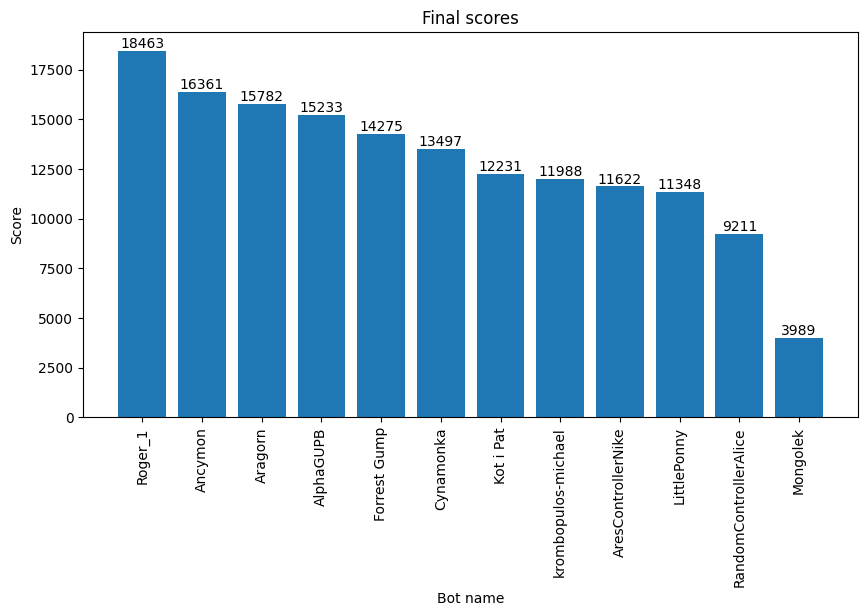

In [13]:
plt.figure(figsize=(10, 5))
plt.bar(final_scores_df["controller_name"].tolist(), final_scores_df["score"].tolist(), width=0.8, align="center")
plt.xticks(rotation=90)
plt.title("Final scores")
plt.xlabel("Bot name")
plt.ylabel("Score")

for i, y in enumerate(final_scores_df["score"].tolist()):
    plt.text(final_scores_df["controller_name"].tolist()[i], y, str(y), ha='center', va='bottom')

plt.show()

## Attacks

In [7]:
all_bots=final_scores_df["controller_name"].tolist()
actions_df = pd.json_normalize(logs_df[logs_df["type"]=="ChampionPickedActionReport"]["value"])
actions_df_count=actions_df.groupby("controller_name")["controller_name"].value_counts().reset_index().rename(columns={"count":"actions_count"})

attack_df = pd.json_normalize(logs_df[logs_df["type"]=="ChampionAttackReport"]["value"])
attack_df_bots=attack_df.groupby("controller_name")["controller_name"].value_counts().reset_index().merge(actions_df_count, how="outer", on="controller_name").fillna(0)
attack_df_bots["attacks/actions"]=attack_df_bots["count"]/attack_df_bots["actions_count"]
# sorting desc
attack_x_bots=attack_df_bots.sort_values(by='count', ascending=False)["controller_name"].tolist()
attack_y_bots=attack_df_bots.sort_values(by='count', ascending=False)["count"].tolist()

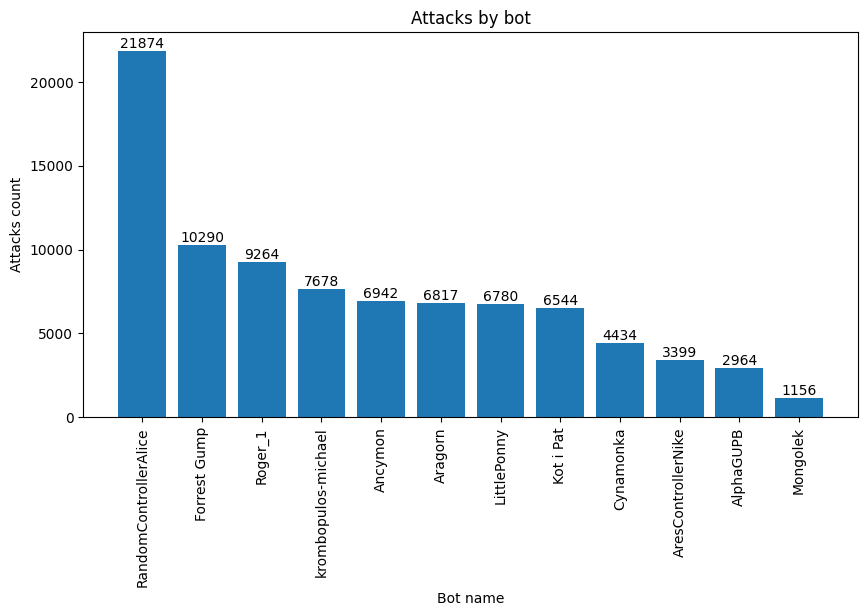

In [10]:
plt.figure(figsize=(10, 5))
plt.bar(attack_x_bots, attack_y_bots, width=0.8, align="center")
plt.xticks(rotation=90)
plt.title("Attacks by bot")
plt.xlabel("Bot name")
plt.ylabel("Attacks count")

for i, y in enumerate(attack_y_bots):
    plt.text(attack_x_bots[i], y, str(y), ha='center', va='bottom')

plt.show()

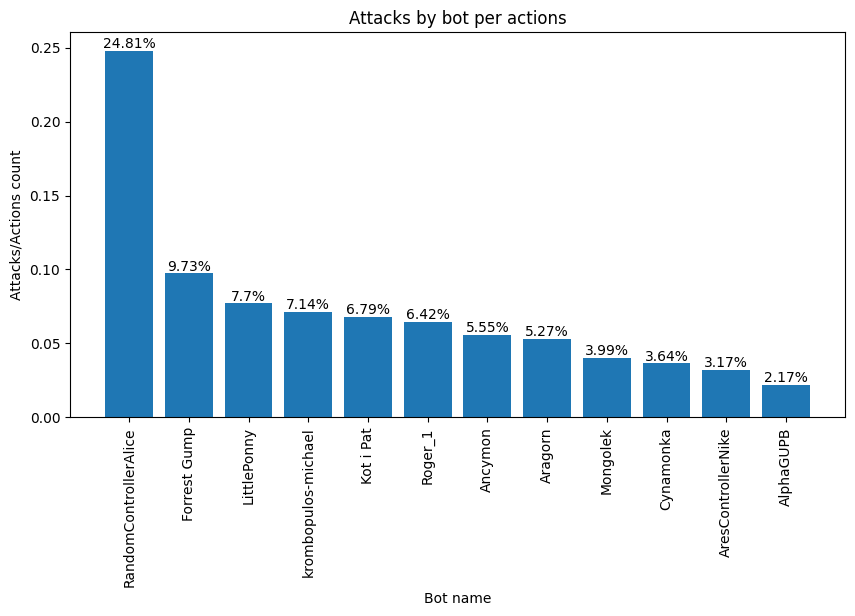

In [11]:
# sorting desc
attack_x_bots=attack_df_bots.sort_values(by='attacks/actions', ascending=False)["controller_name"].tolist()
attack_y_bots=attack_df_bots.sort_values(by='attacks/actions', ascending=False)["attacks/actions"].tolist()

plt.figure(figsize=(10, 5))
plt.bar(attack_x_bots, attack_y_bots, width=0.8, align="center")
plt.xticks(rotation=90)
plt.title("Attacks by bot per actions")
plt.xlabel("Bot name")
plt.ylabel("Attacks/Actions count")

for i, y in enumerate(attack_y_bots):
    plt.text(attack_x_bots[i], y, str(round(y*100, 2))+"%", ha='center', va='bottom')

plt.show()

In [12]:
attack_df_weapon=attack_df.groupby("weapon_name")["weapon_name"].value_counts().reset_index()
attack_df_weapon

,weapon_name,count
0,amulet,12797
1,axe,10511
2,bow_loaded,6773
3,bow_unloaded,6176
4,knife,40411
5,sword,11474


In [13]:
# sorting desc
attack_x_weapon=attack_df_weapon.sort_values(by='count', ascending=False)["weapon_name"].tolist()
attack_y_weapon=attack_df_weapon.sort_values(by='count', ascending=False)["count"].tolist()

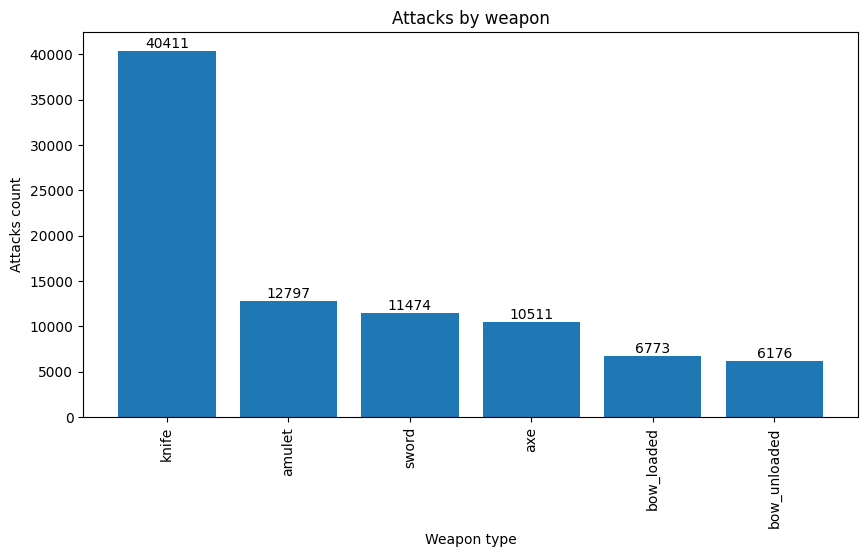

In [14]:
plt.figure(figsize=(10, 5))
plt.bar(attack_x_weapon, attack_y_weapon, width=0.8, align="center")
plt.xticks(rotation=90)
plt.title("Attacks by weapon")
plt.xlabel("Weapon type")
plt.ylabel("Attacks count")

for i, y in enumerate(attack_y_weapon):
    plt.text(attack_x_weapon[i], y, str(y), ha='center', va='bottom')

plt.show()

In [45]:
controller_names = attack_df_bots['controller_name']
weapon_names = attack_df_weapon['weapon_name']
controller_names_dict = {controller_names[idx]: idx for idx in range(len(controller_names))}
weapon_names_dict = {weapon_names[idx]: idx for idx in range(len(weapon_names))}

weapon_per_controller = {controller: {weapon: 0 for weapon in weapon_names} for controller in controller_names}
controller_per_weapon = {weapon: {controller: 0 for controller in controller_names} for weapon in weapon_names}

for action in attack_df.iloc:
    controller = action['controller_name'] # controller_names_dict[action['controller_name']]
    weapon = action['weapon_name'] # weapon_names_dict[action['weapon_name']]
    weapon_per_controller[controller][weapon] += 1
    controller_per_weapon[weapon][controller] += 1

controller_per_weapon

{'amulet': {'AlphaGUPB': 94,
  'Ancymon': 1526,
  'Aragorn': 2690,
  'AresControllerNike': 597,
  'Cynamonka': 590,
  'Forrest Gump': 2059,
  'Kot i Pat': 968,
  'LittlePonny': 1458,
  'Mongolek': 207,
  'RandomControllerAlice': 644,
  'Roger_1': 1005,
  'krombopulos-michael': 959},
 'axe': {'AlphaGUPB': 488,
  'Ancymon': 1591,
  'Aragorn': 1074,
  'AresControllerNike': 482,
  'Cynamonka': 609,
  'Forrest Gump': 1388,
  'Kot i Pat': 978,
  'LittlePonny': 996,
  'Mongolek': 62,
  'RandomControllerAlice': 398,
  'Roger_1': 1647,
  'krombopulos-michael': 798},
 'bow_loaded': {'AlphaGUPB': 343,
  'Ancymon': 489,
  'Aragorn': 0,
  'AresControllerNike': 490,
  'Cynamonka': 555,
  'Forrest Gump': 1273,
  'Kot i Pat': 693,
  'LittlePonny': 652,
  'Mongolek': 110,
  'RandomControllerAlice': 249,
  'Roger_1': 1443,
  'krombopulos-michael': 476},
 'bow_unloaded': {'AlphaGUPB': 259,
  'Ancymon': 456,
  'Aragorn': 0,
  'AresControllerNike': 342,
  'Cynamonka': 526,
  'Forrest Gump': 1241,
  'Kot i 

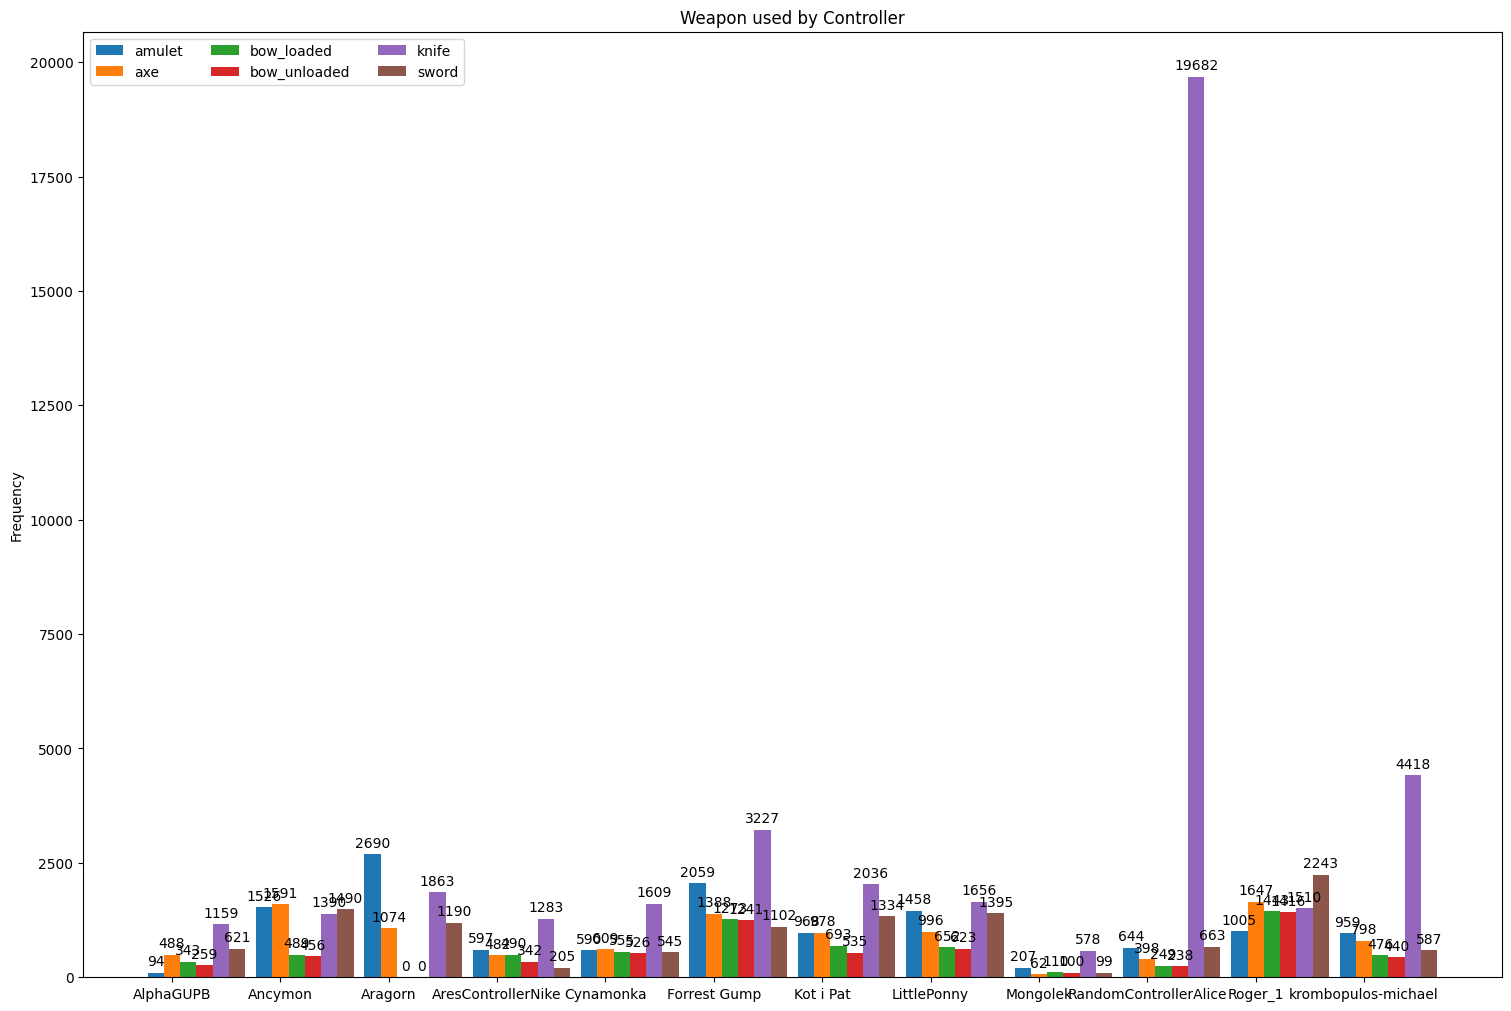

In [59]:
import numpy as np

x = np.arange(len(controller_names))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')


for weapon, count_dict in controller_per_weapon.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count_dict.values(), width, label=weapon)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Frequency')
ax.set_title('Weapon used by Controller')
ax.set_xticks(x + width, controller_names)
ax.legend(loc='upper left', ncols=3)

plt.show()

## Champion Reaction Times

In [8]:
def get_time(timestamp):
    t = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S,%f") 
    return t

def scan_response_times(logs_dict_list):
    '''Get reaction times of each champion.'''
    current_time = None
    champion_times = dict()
    for log_idx, log_dict in enumerate(logs_dict_list):
        if log_dict['type'] == 'ChampionPickedActionReport':
            new_time = log_dict['time_stamp']
            diff = get_time(new_time) - get_time(current_time)
            diff = diff.total_seconds()
            current_time = new_time
            controller = log_dict['value']['controller_name']
            if controller not in champion_times.keys():
                champion_times[controller] = []
            champion_times[controller].append(diff)
        else:
            current_time = log_dict['time_stamp']
    return champion_times 

# tstp = "2023-11-26 19:12:33,232"
# tstp2 = "2023-11-26 19:12:33,235"
# time_1, time_2 = get_time(tstp),  get_time(tstp2) 
# diff = time_2 - time_1
# diff = diff.total_seconds()
# print(diff)  


In [9]:
response_times_dict = scan_response_times(data_dict_list)
# print(response_times_dict['Aragorn'])


In [29]:
# print(response_times_dict['Aragorn'][:5])
avg_response_times = {x: sum(y)/len(y) for x, y in response_times_dict.items()}
avg_response_times['Aragorn']

0.03731330863760639

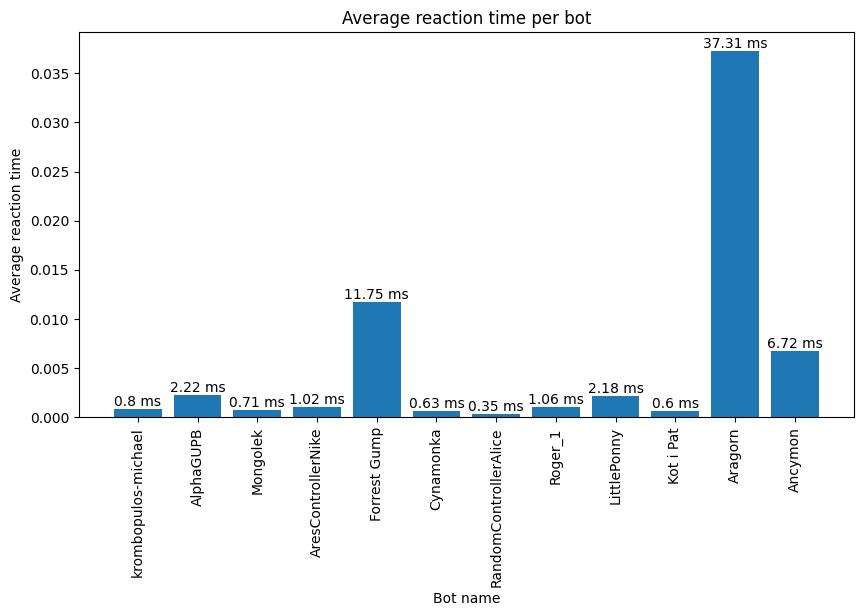

In [37]:
# print("echo")
time_x = list(avg_response_times.keys())
time_y = list(avg_response_times.values())

plt.figure(figsize=(10, 5))
plt.bar(time_x, time_y, width=0.8, align="center")
plt.xticks(rotation=90)
plt.title("Average reaction time per bot")
plt.xlabel("Bot name")
plt.ylabel("Average reaction time")

for i, y in enumerate(time_y):
    plt.text(time_x[i], y, f"{round(y*1000, 2)} ms", ha='center', va='bottom')

plt.show()

## Final Scores in the whole project

In [ ]:
# logfile = "gupb__2023_11_26_19_12_32.json"

logfile_data = []
for logfile in logfile_data:
    data_dict_list = []
    with open(logfile, 'r') as file:
        for line in file:
            try:
                game_data = json.loads(line)
                log_dict = {
                    "time_stamp": game_data["time_stamp"],
                    "severity": game_data["severity"],
                    "line": game_data["line"],
                    "type": game_data["type"],
                    "value": game_data["value"]
                }
                data_dict_list.append(log_dict)
            except json.JSONDecodeError as e:
                print(f'Błąd dekodowania JSON: {e}')
    logfile_data.append(data_dict_list)

In [ ]:
final_scores = {}

for index, data_dict_list in enumerate(logfile_data):
    logs_df=pd.DataFrame(data_dict_list)
    final_scores_df=pd.json_normalize(logs_df[logs_df["type"]=="FinalScoresReport"]["value"].tolist()[0]["scores"])
    # final_scores.append(final_scores_df)
    X, y = final_scores_df["controller_name"].tolist(), final_scores_df["score"].tolist()
    for x in X:
        if x not in final_scores.keys():
            final_scores[x] = {}
        final_scores[x][index] = y

In [ ]:
X = [index for index in range(len(logfile_data))]


for name in final_scores.keys():
    y = []
    for i in len(logfile_data):
        if i in final_scores[x].keys():
            y.append(final_scores[x][i])
        else:
            y.append(0)
    # y = [final_scores[x][i] for i in len(logfile_data) if i in final_scores[x].keys() else 0]
    plt.plot(X, y, color='r', label=name)
  
# Naming the x-axis, y-axis and the whole graph 
plt.xlabel("Bot") 
plt.ylabel("Final Score") 
plt.title("Final Scores across the whole project (so far)") 
  
# Adding legend, which helps us recognize the curve according to it's color 
plt.legend() 
  
# To load the display window 
plt.show() 

## Exceptions raised by each bot

In [61]:
# all_bots=final_scores_df["controller_name"].tolist()
# exception_df = pd.json_normalize(logs_df[logs_df["type"]=="ControllerExceptionReport"]["value"])
exception_logs = logs_df[logs_df["type"]=="ControllerExceptionReport"]["value"]

error_by_bot = {}
bot_by_error = {}
for row in exception_logs:
    controller = row['controller_name']
    exception_name = row['exception']

    if controller not in error_by_bot.keys():
        error_by_bot[controller] = {}
    if exception_name not in error_by_bot[controller].keys():
        error_by_bot[controller][exception_name] = 0
    error_by_bot[controller][exception_name] += 1

    if exception_name not in bot_by_error.keys():
        bot_by_error[exception_name] = {}
    if controller not in bot_by_error[exception_name].keys():
        bot_by_error[exception_name][controller] = 0
    bot_by_error[exception_name][controller] += 1

In [63]:
error_by_bot

{'krombopulos-michael': {'TypeError("\'ExploreHideRunMetaStrat\' object is not callable")': 1000},
 'Mongolek': {'NotImplementedError()': 1000,
  "IndexError('list index out of range')": 16479},
 'Kot i Pat': {"IndexError('list index out of range')": 1062},
 'AlphaGUPB': {'TypeError("\'NoneType\' object is not subscriptable")': 1965,
  "IndexError('list index out of range')": 251},
 'Roger_1': {"IndexError('list index out of range')": 6}}

In [62]:
bot_by_error

{'TypeError("\'ExploreHideRunMetaStrat\' object is not callable")': {'krombopulos-michael': 1000},
 'NotImplementedError()': {'Mongolek': 1000},
 "IndexError('list index out of range')": {'Mongolek': 16479,
  'Kot i Pat': 1062,
  'AlphaGUPB': 251,
  'Roger_1': 6},
 'TypeError("\'NoneType\' object is not subscriptable")': {'AlphaGUPB': 1965}}

In [73]:
import numpy as np

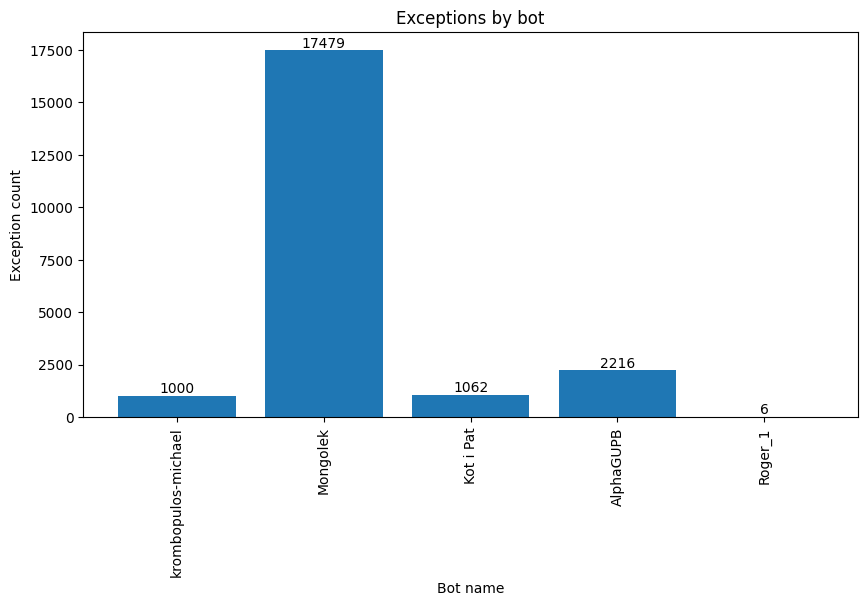

In [81]:
bot_names = list(error_by_bot.keys())
error_names = list(bot_by_error.keys())
ySum = [sum(error_by_bot[name].values()) for name in error_by_bot.keys()]

y_group = [[0 for j in range(len(error_names))] for i in range(len(bot_names))]
for i, bot_name in enumerate(bot_names):
    for j, error_name in enumerate(error_names):
        if error_name in error_by_bot[bot_name].keys():
            y_group[i][j] = error_by_bot[bot_name][error_name]

X = bot_names
# X_axis = np.arange(len(X)) 
plt.figure(figsize=(10, 5))
plt.bar(X, ySum, width=0.8, align="center")
# offset = [-0.2, 0.2]
# for i, row in enumerate(y_group):
#     plt.bar(X_axis + offset[i], row, 0.4, label=bot_names[i]) 
    # for j, j_item in enumerate(row):
    #     plt.text(X[j], j_item, str(j_item), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.title("Exceptions by bot")
plt.xlabel("Bot name")
plt.ylabel("Exception count")

for i, y_item in enumerate(ySum):
    plt.text(X[i], y_item, str(y_item), ha='center', va='bottom')

plt.show()

In [ ]:
X = list(error_by_bot.keys())
ySum = [sum(error_by_bot[name].values()) for name in error_by_bot.keys()]


plt.figure(figsize=(10, 5))
plt.bar(X, ySum, width=0.8, align="center")
plt.xticks(rotation=90)
plt.title("Exceptions by bot")
plt.xlabel("Bot name")
plt.ylabel("Exception count")

for i, y_item in enumerate(ySum):
    plt.text(X[i], y_item, str(y_item), ha='center', va='bottom')

plt.show()